# HW07 - Instrumental Variables (due 16 Nov 2023)

In this homework you will practice with running IV regressions with python. You will investigate once more the effect of schooling on earnings, but this time the instrument for education you will use is college proximity to individuals houses (reference paper by [Card, 1993](https://davidcard.berkeley.edu/papers/geo_var_schooling.pdf)).

More in detail, there are two instruments that can be exploited in this context. Both are binary variables taking value 1 if either a 2-years or 4-years college is present in the area where the individual lives.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
from linearmodels.iv import IV2SLS
from statsmodels.iolib.summary2 import summary_col
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

df = pd.read_stata('http://www.stata.com/data/jwooldridge/eacsap/card.dta')
pd.read_stata('http://www.stata.com/data/jwooldridge/eacsap/card.dta', iterator=True).variable_labels()

{'id': '',
 'nearc2': '=1 if near 2 yr college, 1966',
 'nearc4': '=1 if near 4 yr college, 1966',
 'educ': 'years of schooling, 1976',
 'age': 'in years',
 'fatheduc': "father's schooling",
 'motheduc': "mother's schooling",
 'weight': 'NLS sampling weight, 1976',
 'momdad14': '=1 if live with mom, dad at 14',
 'sinmom14': '=1 if with single mom at 14',
 'step14': '=1 if with step parent at 14',
 'reg661': 'regional dummy, 1966',
 'reg662': '',
 'reg663': '',
 'reg664': '',
 'reg665': '',
 'reg666': '',
 'reg667': '',
 'reg668': '',
 'reg669': '',
 'south66': '=1 if in south in 1966',
 'black': '=1 if black',
 'smsa': '=1 in in SMSA, 1976',
 'south': '=1 if in south, 1976',
 'smsa66': '=1 if in SMSA, 1966',
 'wage': 'hourly wage in cents, 1976',
 'enroll': '=1 if enrolled in school, 1976',
 'kww': 'knowledge world of work score',
 'iq': 'IQ score',
 'married': '=1 if married, 1976',
 'libcrd14': '=1 if lib. card in home at 14',
 'exper': 'age - educ - 6',
 'lwage': 'log(wage)',
 'expe

In [2]:
print(df.columns)
df.head()

Index(['id', 'nearc2', 'nearc4', 'educ', 'age', 'fatheduc', 'motheduc',
       'weight', 'momdad14', 'sinmom14', 'step14', 'reg661', 'reg662',
       'reg663', 'reg664', 'reg665', 'reg666', 'reg667', 'reg668', 'reg669',
       'south66', 'black', 'smsa', 'south', 'smsa66', 'wage', 'enroll', 'kww',
       'iq', 'married', 'libcrd14', 'exper', 'lwage', 'expersq'],
      dtype='object')


,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,sinmom14,...,smsa66,wage,enroll,kww,iq,married,libcrd14,exper,lwage,expersq
0,2,0,0,7,29,NaN,NaN,158413.0,1,0,...,1,548,0,15.0,NaN,1.0,0.0,16,6.306275,256
1,3,0,0,12,27,8.0,8.0,380166.0,1,0,...,1,481,0,35.0,93.0,1.0,1.0,9,6.175867,81
2,4,0,0,12,34,14.0,12.0,367470.0,1,0,...,1,721,0,42.0,103.0,1.0,1.0,16,6.580639,256
3,5,1,1,11,27,11.0,12.0,380166.0,1,0,...,1,250,0,25.0,88.0,1.0,1.0,10,5.521461,100
4,6,1,1,12,34,8.0,7.0,367470.0,1,0,...,1,729,0,34.0,108.0,1.0,0.0,16,6.591674,256


optionally if you want to standardise, you can do it.

In [3]:
#standardise values to ensure minimal problems later
from sklearn.preprocessing import StandardScaler
covariates = ['exper', 'expersq', 'black', 'south', 'smsa', 'reg661', 'reg662', 'reg663', 'reg664', 'reg665', 'reg666', 'reg667', 'reg668', 'reg669']
df = df.dropna(subset=['lwage', 'educ']+covariates)
df = df.drop_duplicates(subset=['lwage', 'educ']+covariates)
# scaler = StandardScaler()
# df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df.shape

(2987, 34)

### OLS

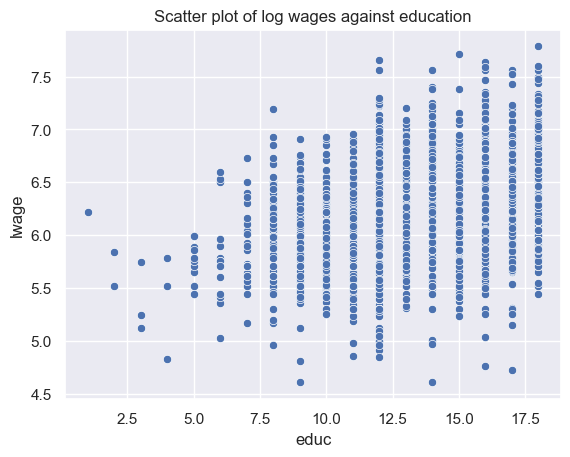

In [4]:
##plot log wages against education
sns.set_theme()
sns.scatterplot(x='educ', y='lwage', data=df)
plt.title('Scatter plot of log wages against education')
plt.show()


In [5]:
##Regress log wages (lwage) against education and include controls, use robust standard errors.
ols_lg_wage = smf.ols(formula='lwage ~ educ + ' + ' + '.join(covariates), data=df).fit(cov_type='HC3')
print(ols_lg_wage.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                 5.645e+04
Date:                Wed, 15 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:12:14   Log-Likelihood:                -1288.1
No. Observations:                2987   AIC:                             2606.
Df Residuals:                    2972   BIC:                             2696.
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2322      0.064     65.980      0.0

**What are other possible confounders?**
- Age, race, region, experience


### 2SLS

You will use only on proximity to a 4-years college ($nearc4$) as instrument. 

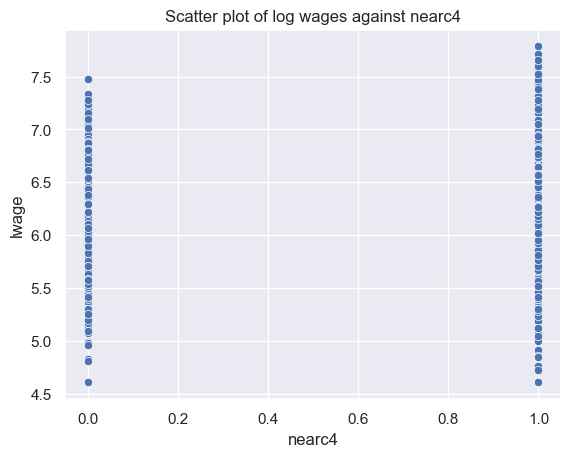

In [6]:
##plot log wages against nearc4
sns.scatterplot(x='nearc4', y='lwage', data=df)
plt.title('Scatter plot of log wages against nearc4')
plt.show()

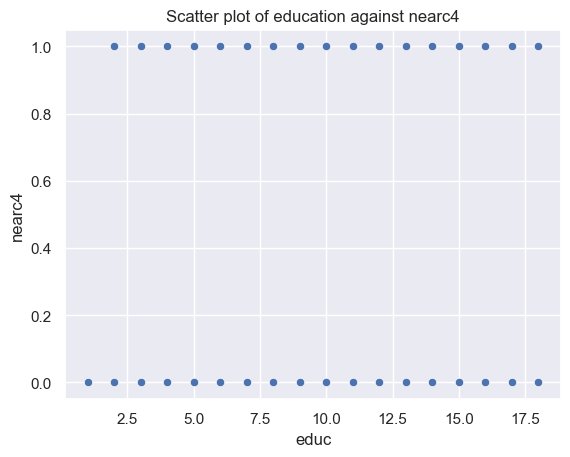

In [7]:
##plot education against nearc4
sns.scatterplot(x='educ', y='nearc4', data=df)
plt.title('Scatter plot of education against nearc4')
plt.show()

**If you run an IV regression of log wages on education, using college proximity as an instrument for education, what would you expect the sign of the coefficient on education to be? Why?**

I expect positive sign since the oriximity will affect both the access to education and possiblity to achieve higher salary positively.

In [8]:
##run a regression of education on nearc4, adding the controls you selected before and using robust standard errors
fs = smf.ols(formula='educ ~ nearc4 + ' + ' + '.join(covariates), data=df).fit(cov_type='HC3')
print(fs.summary())

                            OLS Regression Results                            
Dep. Variable:                   educ   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                 1.090e+04
Date:                Wed, 15 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:12:16   Log-Likelihood:                -6211.2
No. Observations:                2987   AIC:                         1.245e+04
Df Residuals:                    2972   BIC:                         1.254e+04
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.9796      0.141    105.918      0.0

In [9]:
##predict education from the previous regression
df['educhat'] = fs.predict(df)
df[["educ", "educhat"]]

,educ,educhat
0,7,9.748135
1,12,13.439431
2,12,10.691445
3,11,13.272997
4,12,10.921997
...,...,...
3005,12,13.779193
3006,13,11.038115
3007,12,14.180595
3008,12,11.401695


### IV analysis

In [10]:
print(df[covariates].isna().value_counts())
print(df["educ"].isna().value_counts())
print(df["nearc4"].isna().value_counts())

exper  expersq  black  south  smsa   reg661  reg662  reg663  reg664  reg665  reg666  reg667  reg668  reg669
False  False    False  False  False  False   False   False   False   False   False   False   False   False     2987
Name: count, dtype: int64
educ
False    2987
Name: count, dtype: int64
nearc4
False    2987
Name: count, dtype: int64


In [11]:
# Run a regression of log wages on education and controls using robust standard errors
ols_lg_wage_iv = smf.ols(formula='lwage ~ educhat + ' + ' + '.join(covariates), data=df).fit(cov_type='HC3')
print(ols_lg_wage_iv.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                 4.939e+04
Date:                Wed, 15 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:12:16   Log-Likelihood:                -1496.6
No. Observations:                2987   AIC:                             3023.
Df Residuals:                    2972   BIC:                             3113.
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1875      0.774      4.118      0.0

I could not run the standard IV2SLS form from the edogenous and exgenous varoabels due to errors in strong collinearity. I could not find the variables that are collinear clearly despite putting together the covariance matrix. I removed some covariates to make it work.

In [12]:
covariates_changed = ['exper',
 'expersq',
 'black',
 'south',
 'smsa',]

In [13]:
ols_lg_wage_1 = smf.ols(formula='lwage ~ educ + ' + ' + '.join(covariates_changed), data=df).fit(cov_type='HC3')
print(ols_lg_wage_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     215.4
Date:                Wed, 15 Nov 2023   Prob (F-statistic):          7.60e-229
Time:                        22:12:16   Log-Likelihood:                -1306.8
No. Observations:                2987   AIC:                             2628.
Df Residuals:                    2980   BIC:                             2670.
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7315      0.071     66.792      0.0

In [14]:
twosls = IV2SLS(dependent=df['lwage'], 
                exog=sm.add_constant(df[covariates_changed]), 
                endog=df['educ'], 
                instruments=df['nearc4']).fit(cov_type='robust')
print(twosls.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                      0.2265
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2249
No. Observations:                2987   F-statistic:                    785.76
Date:                Wed, Nov 15 2023   P-value (F-stat)                0.0000
Time:                        22:12:16   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          3.7617     0.8193     4.5913     0.0000      2.1559      5.3675
exper          0.1073     0.0211     5.0860     0.00

**What do you think the difference in the estimates is due to?**


The contrintion towards education is much larger compared to the standard OLS regression.  This could be primarily attributed to the the decoupling the education term with the rest of covarites. Earlierm, variation attributed to education is distributed across other covariates too. Hence choosig IV, is a choice to undersatdnd the actual affect. (P value<0.05)

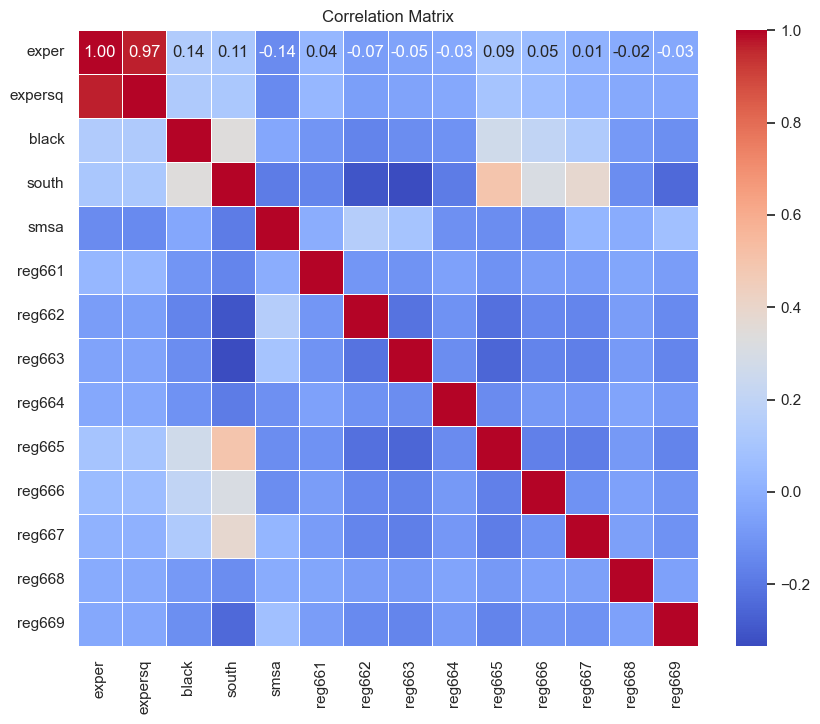


Variance Inflation Factor (VIF):
   Variable        VIF
0     exper  15.589459
1   expersq  15.605318
2     black   1.250783
3     south   3.480705
4      smsa   1.106708
5    reg661   2.054551
6    reg662   4.560891
7    reg663   5.317973
8    reg664   2.292261
9    reg665   8.245840
10   reg666   4.241935
11   reg667   5.121683
12   reg668   1.608846
13   reg669   3.056971


In [15]:
#finding collinearity and correlation
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor


df1 = df[covariates]
def check_correlation_collinearity(df = df1):
    # Calculate correlation matrix
    correlation_matrix = df1.corr()

    # Plot heatmap for correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix')
    plt.show()

    # Calculate VIF for each variable
    vif_data = pd.DataFrame()
    vif_data["Variable"] = df1.columns
    vif_data["VIF"] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    
    # Display VIF results
    print("\nVariance Inflation Factor (VIF):")
    print(vif_data)


check_correlation_collinearity()
